# Addressing outliers in the Kaggle ELO chanllege

This kernel is inspired by https://www.kaggle.com/waitingli/combining-your-model-with-a-model-without-outlier

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error,log_loss

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Training the model without outliers

In [3]:
%%time
train_df = pd.read_csv('../train_v6_fill.csv')
test_df = pd.read_csv('../test_v6_fill.csv')

#train_df = reduce_mem_usage(train_df)
#test_df = reduce_mem_usage(test_df)
#del train_df['Unnamed: 0']
#del test_df['Unnamed: 0']

CPU times: user 10.9 s, sys: 616 ms, total: 11.5 s
Wall time: 11.5 s


In [4]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elasped_time,year,month,is_month_start,outliers,...,category_1_installments_min,category_1_installments_max,category_1_installments_std,authorized_flag_mean,dayofweek,hist_first_buy,hist_last_buy,new_first_buy,new_last_buy,target
0,2017-06-01,C_ID_92a2005557,5,2,1,245,2017,6,True,0,...,0.000000,0.0,NaN,0.950000,3,44.0,209.0,277.0,332.0,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,2017,1,True,0,...,1.000000,1.0,NaN,0.968571,6,61.0,361.0,396.0,453.0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2016,8,True,0,...,0.000000,0.0,NaN,0.953488,0,206.0,263.0,635.0,635.0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,2017,9,True,0,...,0.666667,1.0,0.235702,1.000000,4,NaN,NaN,187.0,229.0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,2017,11,True,0,...,0.941176,1.5,0.395148,0.962406,2,80.0,118.0,121.0,178.0,-0.159749


In [5]:
train_df['outliers'] = 0
train_df.loc[train_df['target']<-30,'outliers']=1
train_df['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [6]:
train_df = train_df[train_df['outliers'] == 0]
target = train_df['target']
#del train_df['target']
to_drop = ['target','Unnamed: 0']
train_df.drop(labels='target' ,axis = 1,inplace = True)
#test_df.drop('Unnamed: 0',axis = 1,inplace = True)

In [7]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elasped_time,year,month,is_month_start,outliers,...,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std,authorized_flag_mean,dayofweek,hist_first_buy,hist_last_buy,new_first_buy,new_last_buy
0,2017-06-01,C_ID_92a2005557,5,2,1,245,2017,6,True,0,...,0.000000,0.000000,0.0,NaN,0.950000,3,44.0,209.0,277.0,332.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,2017,1,True,0,...,1.000000,1.000000,1.0,NaN,0.968571,6,61.0,361.0,396.0,453.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2016,8,True,0,...,0.000000,0.000000,0.0,NaN,0.953488,0,206.0,263.0,635.0,635.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,2017,9,True,0,...,0.833333,0.666667,1.0,0.235702,1.000000,4,NaN,NaN,187.0,229.0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,2017,11,True,0,...,1.220588,0.941176,1.5,0.395148,0.962406,2,80.0,118.0,121.0,178.0


In [8]:
features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','outliers']]
#categorical_feats = [c for c in features if 'feature_' in c]
categorical_feats = ['feature_1','feature_2', 'feature_3','year','month']

In [8]:
features

['feature_1',
 'feature_2',
 'feature_3',
 'elasped_time',
 'year',
 'month',
 'is_month_start',
 'hist_hist_transactions_count',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_category_2_1.0_mean',
 'hist_category_2_2.0_mean',
 'hist_category_2_3.0_mean',
 'hist_category_2_4.0_mean',
 'hist_category_2_5.0_mean',
 'hist_category_3_A_mean',
 'hist_category_3_B_mean',
 'hist_category_3_C_mean',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_state_id_nunique',
 'hist_city_id_nunique',
 'hist_subsector_id_nunique',
 'hist_year_nunique',
 'hist_month_nunique',
 'hist_weekofyear_nunique',
 'hist_weekend_sum',
 'hist_weekend_mean',
 'hist_weekday_sum',
 'hist_weekday_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_median',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_installments_sum',
 'hist_installments_median',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_

In [ ]:
param = {'objective':'regression',
         'num_leaves': 31,
         'min_data_in_leaf': 25,
         'max_depth': 7,
         'learning_rate': 0.01,
         'lambda_l1':0.13,
         "boosting": "gbdt",
         "feature_fraction":0.85,
         'bagging_freq':8,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "verbosity": -1}

In [9]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [ ]:
target.describe()

In [ ]:
n_fold = 5
target_bin = pd.qcut(target,5,range(5))
target_bin.values

In [10]:
#folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=133)
folds = KFold(n_splits=5, shuffle=True, random_state=133)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values,target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval= 100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.62775	valid_1's rmse: 1.63684
[200]	training's rmse: 1.58332	valid_1's rmse: 1.59929
[300]	training's rmse: 1.55793	valid_1's rmse: 1.58102
[400]	training's rmse: 1.54105	valid_1's rmse: 1.57125
[500]	training's rmse: 1.52824	valid_1's rmse: 1.56538
[600]	training's rmse: 1.51774	valid_1's rmse: 1.56171
[700]	training's rmse: 1.50853	valid_1's rmse: 1.55916
[800]	training's rmse: 1.50032	valid_1's rmse: 1.55738
[900]	training's rmse: 1.49257	valid_1's rmse: 1.55598
[1000]	training's rmse: 1.48541	valid_1's rmse: 1.55503
[1100]	training's rmse: 1.4786	valid_1's rmse: 1.5543
[1200]	training's rmse: 1.4721	valid_1's rmse: 1.55373
[1300]	training's rmse: 1.46582	valid_1's rmse: 1.55329
[1400]	training's rmse: 1.45973	valid_1's rmse: 1.55294
[1500]	training's rmse: 1.45386	valid_1's rmse: 1.55279
[1600]	training's rmse: 1.44811	valid_1's rmse: 1.5526
[1700]	training's rmse: 1.44245	valid_1's rmse:

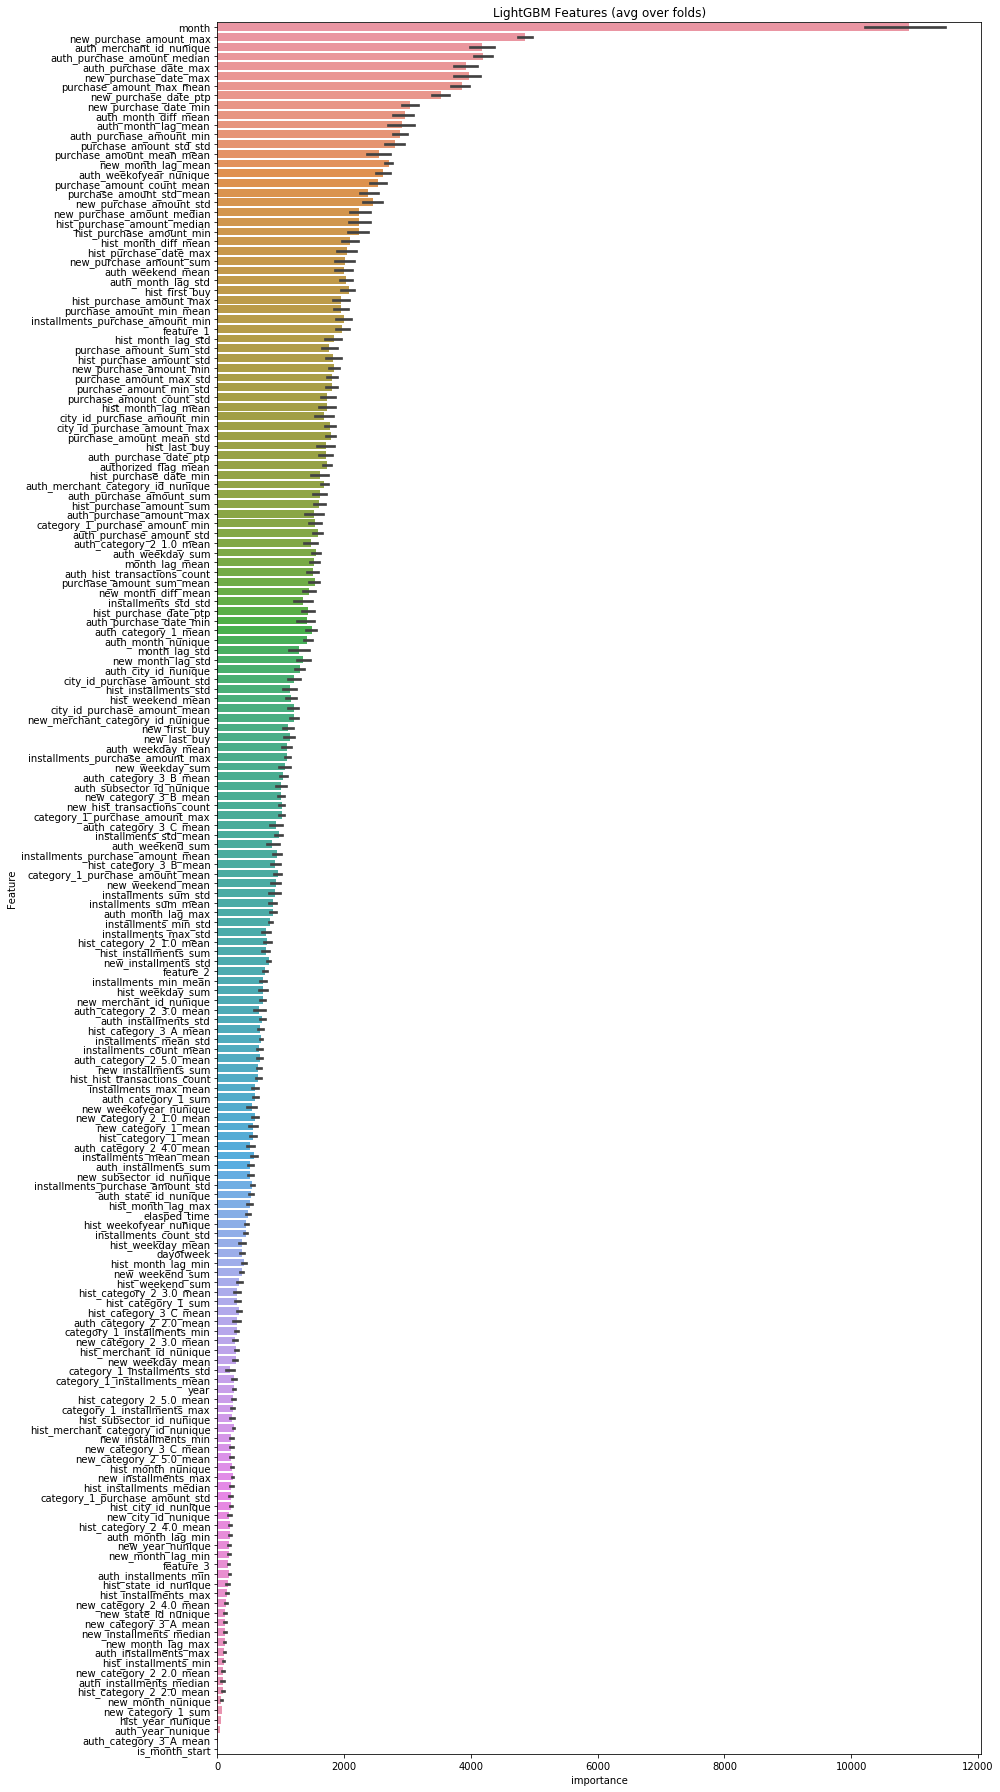

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../lgbm_importances_v6_no_outlier.png')
plt.show()

In [11]:
model_without_outliers = pd.DataFrame({"card_id":test_df["card_id"].values})
model_without_outliers["target"] = predictions

In [12]:
model_without_outliers.to_csv('../model_no_outlier_v6_fill.csv',index=False)

## Training model for outliers classification

In [12]:
train_df = pd.read_csv('../train_v6_fill.csv')
test_df = pd.read_csv('../test_v6_fill.csv')

In [13]:
train_df['outliers'] = 0
train_df.loc[train_df['target']<-30,'outliers']=1

In [14]:
target = train_df['outliers']
del train_df['outliers']
del train_df['target']

In [ ]:
train_df.drop('Unnamed: 0' ,axis = 1,inplace = True)
test_df.drop('Unnamed: 0',axis = 1,inplace = True)

In [15]:
features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month']]
#categorical_feats = [c for c in features if 'feature_' in c]
categorical_feats = ['feature_1','feature_2', 'feature_3','year','month']

In [16]:
features

['feature_1',
 'feature_2',
 'feature_3',
 'elasped_time',
 'year',
 'month',
 'is_month_start',
 'hist_hist_transactions_count',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_category_2_1.0_mean',
 'hist_category_2_2.0_mean',
 'hist_category_2_3.0_mean',
 'hist_category_2_4.0_mean',
 'hist_category_2_5.0_mean',
 'hist_category_3_A_mean',
 'hist_category_3_B_mean',
 'hist_category_3_C_mean',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_state_id_nunique',
 'hist_city_id_nunique',
 'hist_subsector_id_nunique',
 'hist_year_nunique',
 'hist_month_nunique',
 'hist_weekofyear_nunique',
 'hist_weekend_sum',
 'hist_weekend_mean',
 'hist_weekday_sum',
 'hist_weekday_mean',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_median',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_installments_sum',
 'hist_installments_median',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_

In [17]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [18]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

start = time.time()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(log_loss(target, oof)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0427688	valid_1's binary_logloss: 0.047911
[200]	training's binary_logloss: 0.0388509	valid_1's binary_logloss: 0.0459026
[300]	training's binary_logloss: 0.0364223	valid_1's binary_logloss: 0.0453472
[400]	training's binary_logloss: 0.0346903	valid_1's binary_logloss: 0.0451184
[500]	training's binary_logloss: 0.0330688	valid_1's binary_logloss: 0.0450337
[600]	training's binary_logloss: 0.0315819	valid_1's binary_logloss: 0.0450091
[700]	training's binary_logloss: 0.0301456	valid_1's binary_logloss: 0.0449722
[800]	training's binary_logloss: 0.0288399	valid_1's binary_logloss: 0.044986
Early stopping, best iteration is:
[694]	training's binary_logloss: 0.0302492	valid_1's binary_logloss: 0.0449621
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0429841	valid_1's binary_logloss: 0.0475718
[200]	training's binary_logloss: 

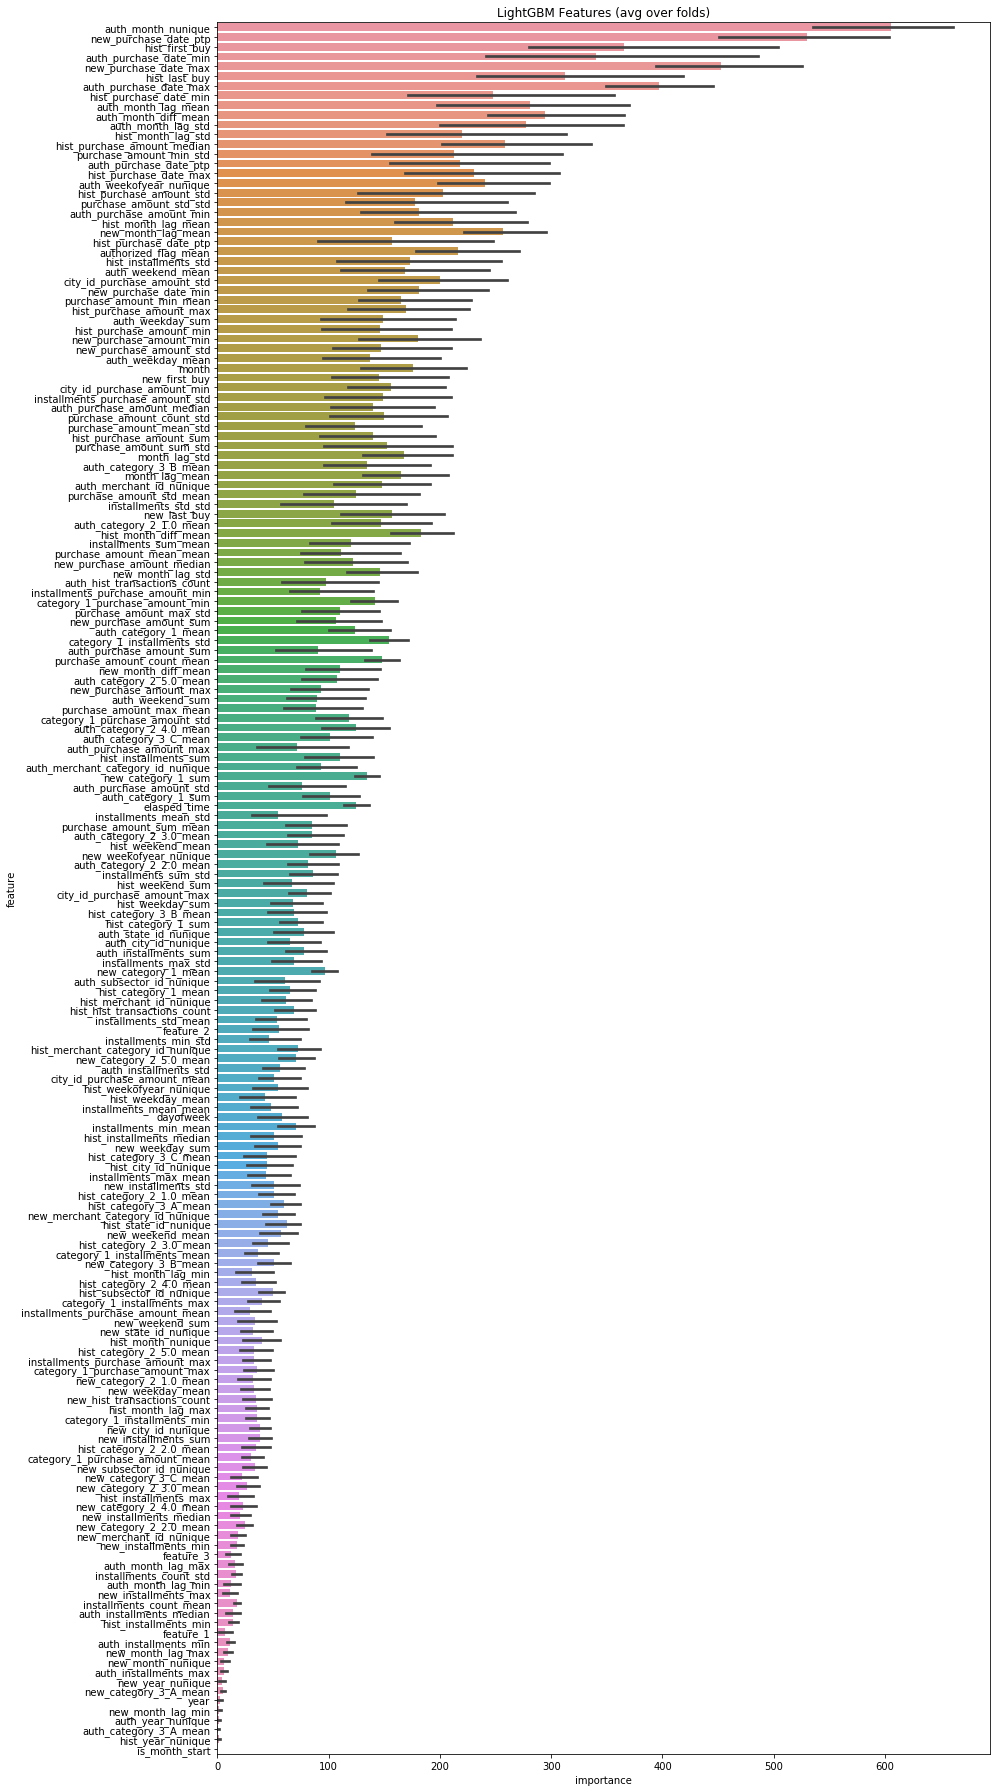

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../lgbm_importances_v6_classifier.png')
plt.show()

In [19]:
df_outlier_prob = pd.DataFrame({"card_id":test_df["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.head()

,card_id,target
0,C_ID_0ab67a22ab,0.075783
1,C_ID_130fd0cbdd,0.001707
2,C_ID_b709037bc5,0.015848
3,C_ID_d27d835a9f,0.000156
4,C_ID_2b5e3df5c2,0.001552


In [29]:
df_outlier_prob.to_csv('../outlier_classifier_v6_fill.csv',index = False)

## Combine for submission

In [ ]:
MDL_no_outlier = pd.read_csv('../model_no_outlier_v5_fill.csv')
MDL_no_outlier.head()

In [20]:
# In case missing some predictable outlier, we choose top 25000 with highest outliers likelyhood.
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target',ascending = False).head(20000)['card_id'])

In [21]:
best_submission = pd.read_csv('../3.695.csv')
#best_submission = pd.read_csv('../submit_v5_combining.csv')

In [22]:
most_likely_liers = best_submission.merge(outlier_id,how='right')
most_likely_liers.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.502326
1,C_ID_b709037bc5,-0.959266
2,C_ID_f7cada36d3,0.411326
3,C_ID_6d8dba8475,-0.893964
4,C_ID_7f1041e8e1,-4.872942


In [ ]:
ix1 = MDL_no_outlier["card_id"].isin(outlier_id["card_id"].values)
ix2 = best_submission["card_id"].isin(outlier_id["card_id"].values)
MDL_no_outlier.loc[ix1, "target"] = best_submission[ix2]["target"]
MDL_no_outlier.to_csv("../submit_v5_repro_20k.csv", index=False)

In [23]:
ix1 = model_without_outliers["card_id"].isin(outlier_id["card_id"].values)
ix2 = best_submission["card_id"].isin(outlier_id["card_id"].values)
model_without_outliers.loc[ix1, "target"] = best_submission[ix2]["target"]

In [24]:
model_without_outliers.to_csv("../submit_v6_20k_dep.csv", index=False)